In [1]:
%pylab inline
import numpy as np
import pandas as pd
import random 
from collections import Counter
from copy import copy
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patches as mpatches
from tqdm import tqdm, tqdm_notebook, tnrange
from tqdm.auto import trange
import seaborn as sns
from MultiAgent import Multi_Agent_DA_with_Type, School_Choice_Algo, MultiBanditEnv, Policy
from utils import Preference_Split
import ipykernel
from scipy.stats import beta

#ipykernel.__version__

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/miniconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def Plot_Regret(rep_regret, rep_type_regret, rep, company_n, T, types_n, quota_comp, quota_worker, left, quota_variant, sub_type=False):
    # Plot the regret for all companies
    fig, ax = plt.subplots(1, 1,figsize=(10,5))
    steps = np.arange(0, T, 1)
    steps_err = np.arange(0, T, 100)

    colors = sns.color_palette("colorblind", 10)
    linestyles = ['--', ':']
    # Calculate the average regret
    avg_regret = np.mean(rep_regret, axis=0)
    # Calculate the maximum regret
    max_regret = np.max(rep_regret, axis=0)
    # Calculate the minimum regret
    min_regret = np.min(rep_regret, axis=0)
    # Calculate the standard deviation of regret
    #std_regret = np.std(rep_regret, axis=0)

    avg_type_regret = np.mean(rep_type_regret, axis=0)

    for i in range(company_n):
        ax.plot(steps, avg_regret[i], color = colors[i], linewidth=2.0, label = 'Company ' + str(i+1))
        if sub_type:
            for j in range(types_n):
                # with dashed line
                ax.plot(steps, avg_type_regret[i, j], color = colors[i], linewidth=1.0, linestyle=linestyles[j], label = 'Company ' + str(i+1) + ' Type ' + str(j+1))
        #ax.fill_between(steps, max_regret[i], min_regret[i], facecolor = colors[i], alpha=0.2)     
        #ax.errorbar(steps_err, avg_regret[i, steps_err], yerr=std_regret[i, steps_err], fmt="o", capsize=10)


    ax.legend(loc = 'upper left')

    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Regret")
    #ax.set_xticks(np.arange(0, T, 1))
    #ax.set_xticklabels(np.arange(1, N+1, 1))
    #ax.grid(color='blue', axis = 'x', linestyle='-', linewidth=1, alpha=0.2)
    fig.tight_layout()
    plt.show()

    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages("../fig/Regret_C_%d_T_%d_QC_%s_QW_%s*2_T_%d_Ber_left_%d_%s.pdf" % (company_n, types_n, quota_comp, quota_worker, T, left, quota_variant))
    pdf.savefig(fig, bbox_inches="tight")
    pdf.close()

In [3]:
def Print_Optimal(multi_agent_TS, env, left, ori_pref_matrix, company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota):
    if left == 0:
        result_company, not_converge = Multi_Agent_DA_with_Type(ori_pref_matrix, company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota, 0)
        for key in result_company.keys():
            print(key, result_company[key])
    else:
        result_company, not_converge = Multi_Agent_DA_with_Type(ori_pref_matrix, company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota, 0)
        unpack_match_optimal_result = multi_agent_TS.Unpack_Matching_Result(result_company)

        quota_left_status = multi_agent_TS.Check_Quota_Status()

        # rank all workers based on ds_sampled_mean and sde_sampled_mean
        ds_true_mean_ac = []
        sde_true_mean_ac = []
        ds_true_mean_rank_ac = []
        sde_true_mean_rank_ac = []
        for i in range(env.company_n):
            ds_true_mean_ac.append(env.true_mean['f_%d' % (i+1)]['ds'])
            sde_true_mean_ac.append(env.true_mean['f_%d' % (i+1)]['sde'])
            ds_true_mean_rank_ac.append(env.true_rank['f_%d' % (i+1)]['ds'])
            sde_true_mean_rank_ac.append(env.true_rank['f_%d' % (i+1)]['sde'])

        left_true_mean = multi_agent_TS.Rank_left_Workers(unpack_match_optimal_result, quota_left_status, ds_true_mean_rank_ac, sde_true_mean_rank_ac, ds_true_mean_ac, sde_true_mean_ac)            
        # remove the matched workers from the left preference
        left_true_pref = multi_agent_TS.Rorder_left_pref(left_true_mean)
        
        left_true_match, _ = School_Choice_Algo(left_true_pref, env.company_n, \
            env.types_n, env.worker_ds_n, env.worker_sde_n, quota_left_status)
        # update the matching result
        unpack_match_left_optimal_result= multi_agent_TS.Unpack_Left_Matching_Result(left_true_match)
        # add the left into the first matching result.
        for i in range(env.company_n):
            unpack_match_optimal_result['f_%d' % (i+1)]['ds'] += unpack_match_left_optimal_result['f_%d' % (i+1)]['ds']
            unpack_match_optimal_result['f_%d' % (i+1)]['sde'] += unpack_match_left_optimal_result['f_%d' % (i+1)]['sde']

        matching_result_plus_one = multi_agent_TS.REFORM_RESULT(unpack_match_optimal_result)
        for key in matching_result_plus_one.keys():
            print(key, matching_result_plus_one[key])

In [4]:
selection_method='random'
seed = 90025
quota_variant = 'single' #'multiple'[first match is multiple >=2]  # or 'single'
left = 1
types_n = 2
T = 3000

if quota_variant == 'single':
    company_n = 100
    worker_ds_n = 300
    worker_sde_n = 300
    company_ds_quota = [1 for i in range(company_n)] 
    company_sde_quota = [1 for i in range(company_n)]
    # for each company, the quota is the sum of the two quotas for each company + 1
    company_quota = [company_ds_quota[i] + company_sde_quota[i] + left for i in range(company_n)]  # [3,3]
    
elif quota_variant == 'multiple':
    company_n = 2
    worker_ds_n = 5
    worker_sde_n = 5
    company_ds_quota = [2 for i in range(company_n)] 
    company_sde_quota = [2 for i in range(company_n)]
    # for each company, the quota is the sum of the two quotas for each company + 1
    company_quota = [company_ds_quota[i] + company_sde_quota[i] + left for i in range(company_n)]

# check if the quota is valid.
try:
    assert sum(company_quota) <= worker_ds_n + worker_sde_n
    print('Quota is valid')
except:
    print("The quota is not enough for the workers")

#prefer_matrix = matching_pref(company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota, selection_method, seed)

Quota is valid


In [5]:
instance_seed = 90095
seed = 90095
rep = 2
rep_regret = np.zeros((rep, company_n, T))
rep_type_regret = np.zeros((rep, company_n, types_n, T))
sub_type = True
for i in tqdm(range(rep)):
    env = MultiBanditEnv(company_n, types_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota, T, seed+i)
    true_mean, true_rank = env.True_Mean(instance_seed)
    rewards = env.Rewards() # T * company_n * types_n * worker_n
    prefer_matrix = env.True_Preference(instance_seed)
    
    '''
    print(prefer_matrix)
    Stable matching result
    result_company, not_converge = Multi_Agent_DA_with_Type(prefer_matrix, company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota, 0)
    for key in result_company.keys():
        print(key, result_company[key])
    '''
    ori_pref_matrix, true_comp_to_worker_pref, true_worker_to_comp_pref = Preference_Split(prefer_matrix, company_n)
    

    # Policy learning
    multi_agent_TS = Policy(company_n, types_n, worker_ds_n, worker_sde_n, company_quota, company_ds_quota, company_sde_quota, T, Multi_Agent_DA_with_Type, \
        School_Choice_Algo, ori_pref_matrix, true_comp_to_worker_pref, true_worker_to_comp_pref, env, seed+1)

    beta_prior = multi_agent_TS.Beta_Prior() # company_n * types_n * worker_n * 2
    multi_agent_TS.Policy_TS()

    regret = multi_agent_TS.Instant_Regret()
    overall_regret, overall_regret_all_type = multi_agent_TS.Overall_Regret()
    rep_regret[i] = overall_regret_all_type
    rep_type_regret[i] = overall_regret

print("\n Current Matching Result")
print(multi_agent_TS.matching_result_plus_one)

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


 Current Matching Result
{'f_1': {'ds': [2, 4], 'sde': [1, 5, 3]}, 'f_2': {'ds': [3, 1, 5], 'sde': [4, 2]}}


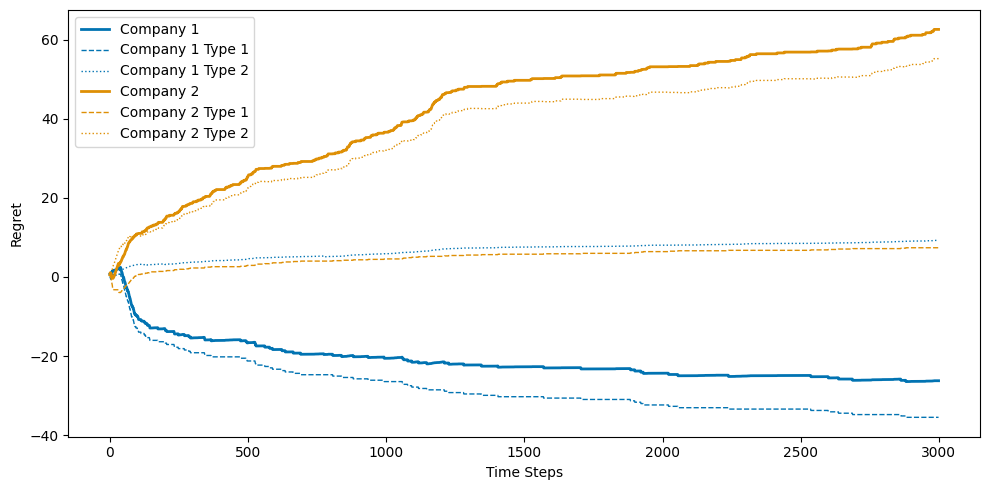

In [6]:
# Plot over multiple runs   
Plot_Regret(rep_regret, rep_type_regret, rep, company_n, T, types_n, company_quota, worker_ds_n, left, quota_variant,sub_type)

In [18]:
# Preferences from workers to companies
print("\n Preferences from workers to companies: %s" % (prefer_matrix))
# Preferences from companies to workers
print("\n Preferences from companies workers, %s" % ori_pref_matrix)

# Ture mean of the companies
print("\n The True mean is:")
for key in env.true_mean.keys():
    print(key, np.round(env.true_mean[key]['ds'], 3), np.round(env.true_mean[key]['sde'], 3))
# Esitmated mean of the companies
 
# Estimated Mean
for i in range(company_n):
    print("\nf_%d" % (i+1))
    mean_ds = []
    mean_sde = []
    for j in range(worker_ds_n):
        a,b = multi_agent_TS.beta_prior['f_%d' % (i+1)]['ds'][j,:]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        mean_ds.append(np.round(mean, 3))
    for j in range(worker_sde_n):
        a,b = multi_agent_TS.beta_prior['f_%d' % (i+1)]['sde'][j,:]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        mean_sde.append(np.round(mean, 3))
    print(mean_ds, mean_sde)
    
# our matching reuslt
print('\n Our Matching Result: %s' % multi_agent_TS.matching_result_plus_one)
print("\n Optimal Matching Result")
Print_Optimal(multi_agent_TS, env, left, ori_pref_matrix, company_n, worker_ds_n, worker_sde_n, company_ds_quota, company_sde_quota)


 Preferences from workers to companies: {'D_1': ['f_1', 'f_2'], 'D_2': ['f_1', 'f_2'], 'D_3': ['f_2', 'f_1'], 'D_4': ['f_1', 'f_2'], 'D_5': ['f_2', 'f_1'], 'S_1': ['f_1', 'f_2'], 'S_2': ['f_1', 'f_2'], 'S_3': ['f_2', 'f_1'], 'S_4': ['f_2', 'f_1'], 'S_5': ['f_1', 'f_2']}

 Preferences from companies workers, {'f_1': [['D_4', 'D_2', 'D_3', 'D_5', 'D_1'], ['S_1', 'S_4', 'S_5', 'S_2', 'S_3']], 'f_2': [['D_2', 'D_3', 'D_1', 'D_5', 'D_4'], ['S_4', 'S_2', 'S_5', 'S_1', 'S_3']], 'D_1': ['f_1', 'f_2'], 'D_2': ['f_1', 'f_2'], 'D_3': ['f_2', 'f_1'], 'D_4': ['f_1', 'f_2'], 'D_5': ['f_2', 'f_1'], 'S_1': ['f_1', 'f_2'], 'S_2': ['f_1', 'f_2'], 'S_3': ['f_2', 'f_1'], 'S_4': ['f_2', 'f_1'], 'S_5': ['f_1', 'f_2']}

 The True mean is:
f_1 [0.406 0.956 0.738 0.97  0.695] [0.932 0.241 0.04  0.657 0.289]
f_2 [0.682 0.909 0.823 0.204 0.218] [0.303 0.849 0.131 0.886 0.428]

 Our Matching Result: {'f_1': {'ds': [2, 4], 'sde': [1, 5, 3]}, 'f_2': {'ds': [1, 3, 5], 'sde': [4, 2]}}

 Optimal Matching Result
f_1 {

# Check the optimal is correct

In [9]:
# Consider all the possible matching preference
'''
not_converges = 0
result_companies = {}
for id in range(len(prefer_matrix)):
    result_company, not_converge = gs_matching_two_by_four(prefer_matrix[id], id)
    result_companies[id] = result_company
    not_converges += not_converge

# Stable matching Rate
print('Stable Matching Rate: %.2f' % (1 - not_converges/len(prefer_matrix)))
'''

"\nnot_converges = 0\nresult_companies = {}\nfor id in range(len(prefer_matrix)):\n    result_company, not_converge = gs_matching_two_by_four(prefer_matrix[id], id)\n    result_companies[id] = result_company\n    not_converges += not_converge\n\n# Stable matching Rate\nprint('Stable Matching Rate: %.2f' % (1 - not_converges/len(prefer_matrix)))\n"